# LCCS Level 4 Test Notebook

A notebook which mirrors the main `le_lccs_odc.py` script and reads all parameters from the config file but allows more interactive manipulation of the input and output layers

In [1]:
# import importlib
# import sys
# import os
# service = "home/joyvan"
# from datacube.virtual import DEFAULT_RESOLVER
# sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
# sys.path.append(str(service)+"dea-notebooks/Scripts")
# sys.path.append(str(service)+"livingearth_australia")

# #see what's already in the resolver 
# DEFAULT_RESOLVER.lookup_table['transform']

# # Now we add the transformation we're testing
# # Get location of transformation
# # transformation = "le_plugins.salt_mask_new"
# # trans_loc = importlib.import_module(transformation)
# # trans_class = transformation.split('.')[-1]
# # DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [2]:
# ! export PYTHONPATH=/home/jovyan/development/dea-notebooks/Scripts:/home/jovyan/development/livingearth_australia/:/home/jovyan/livingearth_lccs/le_lccs
# ! export LE_LCCS_PLUGINS_PATH=/home/jovyan/development/livingearth_australia/le_plugins

In [3]:
import argparse
import logging
import os
import sys
import yaml

import numpy
import xarray
from matplotlib import pyplot

sys.path.append(os.path.abspath("/home/jovyan/development/livingearth_australia/le_plugins"))
sys.path.append("/home/jovyan/development/dea-notebooks/Scripts")
sys.path.append("/home/jovyan/development/livingearth_australia")
sys.path.append("/home/jovyan/livingearth_lccs")

os.environ["LE_LCCS_PLUGINS_PATH"] = "/home/jovyan/development/livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs import le_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

In [4]:
yaml_sites_file = os.path.abspath("../Gabrielle_dev/au_test_sites.yaml") #"../cultivated_ml/au_test_sites.yaml"
config_file = os.path.abspath("../../../development/livingearth_australia/templates/l4_vp_template.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Brisbane"

year = "2015"

extent = [site_config[site_name]["min_x"],
          site_config[site_name]["min_y"],
          site_config[site_name]["max_x"],
          site_config[site_name]["max_y"]]

output_dir = "/tmp/"

out_name_base = "lccs_l4_tests_20191209_{}_{}".format(site_name.replace(" ","_"), year)
output_l3_file_name = os.path.join(output_dir, "{}_level3.tif".format(out_name_base))
output_l3_rgb_file_name = os.path.join(output_dir, "{}_level3_rgb.tif".format(out_name_base))
output_l4_file_name = os.path.join(output_dir, "{}_level4.nc".format(out_name_base))
output_l4_rgb_file_name = os.path.join(output_dir, "{}_level4_rgb.tif".format(out_name_base))

In [11]:
# Read in config file
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

# Set up dictionary to define size parameters
target_size = {}
# If an extent is provided then use this instead of the values
# in the config file
if extent is not None:
    if not isinstance(extent, list) or len(extent) != 4:
        raise TypeError("Extent must be a list with 4 values")

    else:
        target_size["target_min_x"] = extent[0]
        target_size["target_max_x"] = extent[2] - 1000
        target_size["target_min_y"] = extent[1]
        target_size["target_max_y"] = extent[3] - 1000
else:
    target_size["target_min_x"] = config["extent"]["min_x"]
    target_size["target_max_x"] = config["extent"]["max_x"]
    target_size["target_min_y"] = config["extent"]["min_y"]
    target_size["target_max_y"] = config["extent"]["max_y"]

target_size["target_pixel_size_x"] = config["resolution"][0]
target_size["target_pixel_size_y"] = config["resolution"][1]

target_size["target_crs"] = config["crs"]

# Set up list of input layers to read in
# Try to read all level 3 layers
try:
    input_layers = config["L3layers"]
# If no 'L3layers' defined in the config file
# try 'Layers' (format used for older Level3 only config files)
except KeyError:
    input_layers = config["Layers"]

# Check if outputs are defined for level 4
# classification
export_level4_data = False
export_level4_rgb = False
apply_l4_classification = False

# See if the config file has sections specifying a level4 output
# if they don't assume no level4 classification is needed.
try:
    config["Outputs"]["level4_data"]
    export_level4_data = True
    apply_l4_classification = True
except KeyError:
    if output_l4_file_name is not None:
        logging.warning("Filename for Level 4 output has been passed in but"
                        " export class not defined in config so can not export")
    pass

try:
    config["Outputs"]["level4_rgb"]
    export_level4_rgb = True
    apply_l4_classification = True
except KeyError:
    if output_l4_rgb_file_name is not None:
        logging.warning("Filename for Level 4 output has been passed in but"
                        " export class not defined in config so can not export")
    pass

# If a level4 output file is required read in input
# layers needed for it at same time as level3 inputs
if apply_l4_classification:
    try:
        input_layers_l4 = config["L4layers"]
    except KeyError:
        raise KeyError("Level 4 output specified but no "
                       " 'L4layers' defined in input config")
    input_layers.update(input_layers_l4)

# Read each into xarray and save to list
logging.info("Reading in data")
variables_xarray_list = []
layer_names = []
for var_name, ingest_parameters in input_layers.items():
    # TODO: Need to write a wrapper to make recursive calls of `getattr` nicer.
    # Don't run any of the 'xarray_maths' classes yet - nead to load all other
    # variables first
    import_class_name = ingest_parameters["ingest_class"]
        # Get the class to use for importing
    if import_class_name != "xarray_maths":
        import_class = getattr(getattr(le_ingest, import_class_name.split(".")[0]),
                              import_class_name.split(".")[1])
        # Set up instance of import class
        import_obj = import_class(**target_size)

        # Import
        ingest_parameters["variable_name"] = var_name
        variables_xarray = import_obj.read_to_xarray(**ingest_parameters)
        variables_xarray_list.append(variables_xarray)
        layer_names.append(var_name)

# Merge to a single dataset
classification_data = xarray.merge(variables_xarray_list)

# Apply band maths (if any)
logging.info("  Applying band maths")
for var_name, ingest_parameters in input_layers.items():
    import_class_name = ingest_parameters["ingest_class"]
    if import_class_name == "xarray_maths":
        # Set up instance of import class
        variables_xarray_list.append(le_ingest.ingest_base.LEIngest().xarray_maths(
            classification_data, var_name, layer_names,
            ingest_parameters["expstr"]))

# Make new stack with additional layers
classification_data = xarray.merge(variables_xarray_list)

# Get dimensions (tuple)
classification_dims = classification_data["vegetat_veg_cat"].dims

# Apply Level 3 classification
logging.info("Applying Level 3 Classification")
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

# Get colour scheme
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3)

level3_out_xarray = xarray.Dataset(
    {"level1" : (classification_dims, level1),
     "level2" : (classification_dims, level2),
     "level3" : (classification_dims, level3),
     "Red" : (classification_dims, red),
     "Green" : (classification_dims, green),
     "Blue" : (classification_dims, blue)},
    coords=classification_data.coords)

# Write out
export_level3_data = False
export_level3_rgb = False

# Check if outputs have been defined for level3
try:
    config["Outputs"]["level3_data"]
    export_level3_data = True
except KeyError:
    pass

try:
    config["Outputs"]["level3_rgb"]
    export_level3_rgb = True
except KeyError:
    pass

# If a level4 output file is specified perform classification
if apply_l4_classification:
    logging.info("Applying Level 4 Classification")

    # Join level3 to rest of classification data
    level3_xarray = xarray.Dataset({"level3" : (classification_dims, level3)},
                                   coords=classification_data.coords)

    classification_data = xarray.merge([classification_data, level3_xarray])

    # Apply classificaation
    l4_out_classification_array = lccs_l4.classify_lccs_level4(classification_data)

    # Get colourscheme based on class code
    logging.info("  Getting colours")
    red, green, blue, alpha = lccs_l4.colour_lccs_level4(l4_out_classification_array)

    l4_classification_codes_colours = xarray.Dataset(
        {"Red" : (classification_dims, red),
         "Green" : (classification_dims, green),
         "Blue" : (classification_dims, blue)})

    l4_out_classification_array = xarray.merge([l4_out_classification_array,
                                                l4_classification_codes_colours])

/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
tcw <xarray.Dataset>
Dimensions:      (time: 46, x: 990, y: 990)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 2e+06 2e+06 2e+06 ... 2.099e+06 2.099e+06 2.099e+06
  * y            (y) float64 -3.101e+06 -3.101e+06 ... -3.2e+06 -3.2e+06
  * time         (time) datetime64[ns] 2015-01-02T23:48:20.181383 ... 2015-12...
Data variables:
    TCW          (time, y, x) float32 dask.array<chunksize=(1, 990, 990), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

This should work
all_wet <xarray.DataArray 'TCW' (time: 46, y: 990, x: 990)>
dask.array<gt, shape=(46, 990, 990), dtype=bool, chunksize=(1, 990, 990), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 2e+06 2e+06 2e+06 ... 2.099e+06 2.099e+06 2.099e+06
  * y            (y) float64 -3.101e+06 -3.101e+06 ... -3.2e+06 -3.2e+06
  * t

/home/jovyan/development/dea-notebooks/Scripts/dea_bandindices.py:280: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


annual_tcw result <xarray.DataArray (y: 990, x: 990)>
array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 2e+06 2e+06 2e+06 ... 2.099e+06 2.099e+06 2.099e+06
  * y            (y) float64 -3.101e+06 -3.101e+06 ... -3.2e+06 -3.2e+06


VirtualProductException: transformation <class 'le_plugins.MLClassification.MLClassification'> could not be instantiated

In [7]:
classification_data

<xarray.Dataset>
Dimensions:                  (x: 990, y: 990)
Coordinates:
    spatial_ref              int32 3577
  * x                        (x) float64 2e+06 2e+06 ... 2.099e+06 2.099e+06
  * y                        (y) float64 -3.101e+06 -3.101e+06 ... -3.2e+06
Data variables:
    fc_veg                   (y, x) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    saltpan_mask             (y, x) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    mudflat_mask             (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    DEM                      (y, x) bool False False False ... True True True
    wofs_mask                (y, x) bool False False False ... True True True
    item_v2_mask             (y, x) bool False False False ... False False False
    mangrove                 (y, x) bool False False False ... False False False
    cultman_agr_cat          (y, x) bool False False False ... False False False
    tf_urban_classification  (y, x) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mads_urban_mask_sdev     (y, x) bool False False False ... False False False
    mads_urban_mask_edev     (y, x) bool False False False ... False False False
    wcf_mask                 (y, x) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    wofs_sum_mask            (y, x) bool False False False ... True True True
    vegetat_veg_cat          (y, x) bool True True True ... False False False
    aquatic_wat_cat          (y, x) bool False False False ... True True True
    artific_urb_cat          (y, x) bool False False False ... False False False

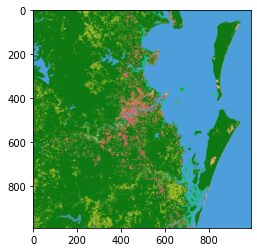

In [8]:
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

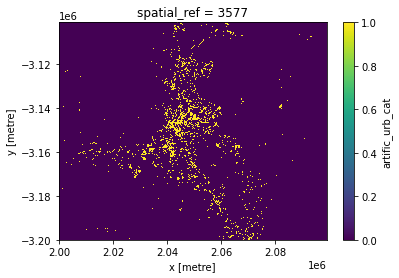

In [9]:
classification_data["artific_urb_cat"].plot()

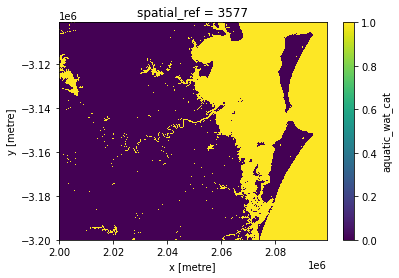

In [10]:
classification_data["aquatic_wat_cat"].plot()